In [1]:
import os, sys, importlib
sys.path.append('../')

import common_utils
from common_utils import plotting, training
import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.optimizers import Nadam
import mplhep as hep
import matplotlib.pyplot as plt
hep.style.use(hep.style.ATLAS)


/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:10: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style("ATLAS")
2025-02-10 10:57:37.329111: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-10 10:57:38.447712: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [22]:
saved_data = './cached_data/'

dataset = pd.read_hdf(f"{saved_data}dataset_preselected_ttbar.h5", key="dataset", mode='r')

mask_ttbar = dataset.type=='ttbar'
mask_singletop = dataset.type=='single_top_t_chan'
mask_wjets = dataset.type=='wjets'

# mask that extracts the expected Asimov dataset - 
# trivially the full dataset for the ttbar dataset used here, 
# but not generally true
mask_Asimov = (dataset.type=='ttbar') | (dataset.type=='single_top_t_chan') | (dataset.type=='wjets')
weights_Asimov = dataset[mask_Asimov].weights.ravel()

dataset_ttbar = dataset[mask_ttbar].copy()
dataset_single_top = dataset[mask_singletop].copy()
dataset_wjets = dataset[mask_wjets].copy()

nu_ttbar = dataset_ttbar.weights.sum()
print(f"expected ttbar yield = {nu_ttbar} events")

nu_singletop = dataset_single_top.weights.sum()
print(f"expected single top yield = {nu_singletop}")

nu_wjets = dataset_wjets.weights.sum()
print(f"expected wjets yield = {nu_wjets}")

expected ttbar yield = 4827143.199423024 events
expected single top yield = 293316.6674714682
expected wjets yield = 22259892.766995974


In [29]:
path_to_ratios_wjets = './output_ratios_wjets/'
path_to_ratios_singletop = './output_ratios_singletop/'

files_wjets = glob.glob(f"{path_to_ratios_wjets}ratio_*.npy")
files_singletop = glob.glob(f"{path_to_ratios_singletop}ratio_*bs512*.npy")

ratios = {}
ratios['wjets'] = np.load(files_wjets[0])[mask_Asimov]
ratios['singletop'] = np.load(files_singletop[0])[mask_Asimov]
ratios['ttbar'] = np.ones_like(ratios['wjets'])[mask_Asimov]


In [24]:
ratios['singletop']


array([0.9780628 , 0.93577087, 1.0188538 , ..., 1.1785129 , 0.9235641 ,
       0.9738464 ], dtype=float32)

In [21]:
ratios['singletop']

array([0.96204007, 0.92525095, 1.0049189 , ..., 1.2356523 , 0.91345817,
       0.95681095], dtype=float32)

In [32]:
# Build the model

# Get the weight vector corresponding to a given mu hypothesis
def dataset_mu_morph_weights(dataset, mu):

    weights_morphing =  dataset['weights'].ravel()
    weights_morphing[dataset.type=='ttbar'] *= mu

    return weights_morphing

# rate term
def nu(mu):

    nu = mu * nu_ttbar + nu_singletop + nu_wjets

    return nu


# per event term
def log_ratio_mu(mu):

    dnu_mu = mu * nu_ttbar * ratios['ttbar'][mask_Asimov]\
                + nu_singletop * ratios['singletop'][mask_Asimov]\
                + nu_wjets * ratios['wjets'][mask_Asimov]

    return np.log( dnu_mu / nu(mu) ) 

# The full NLL function
def full_nll_function(mu, mu_Asimov=1.0):

    pois_llr = -2 * nu(mu_Asimov) * np.log(nu(mu)) + 2 * nu(mu)
    nsbi_llr = -2 * np.sum(np.multiply(weights_Asimov, log_ratio_mu(mu)))

    return pois_llr + nsbi_llr

In [36]:
# Normally we use minuit for this step - but this is a quick first draft script 
mu_scan_range = np.linspace(0.0, 3.0, num=100)

tmu_arr = np.zeros_like(mu_scan_range)

for count, mu in enumerate(mu_scan_range):
    tmu_arr[count] = full_nll_function(mu)

In [37]:
tmu_arr -= np.amin(tmu_arr)

(0.0, 3.0, 0.0, 6000000.0)

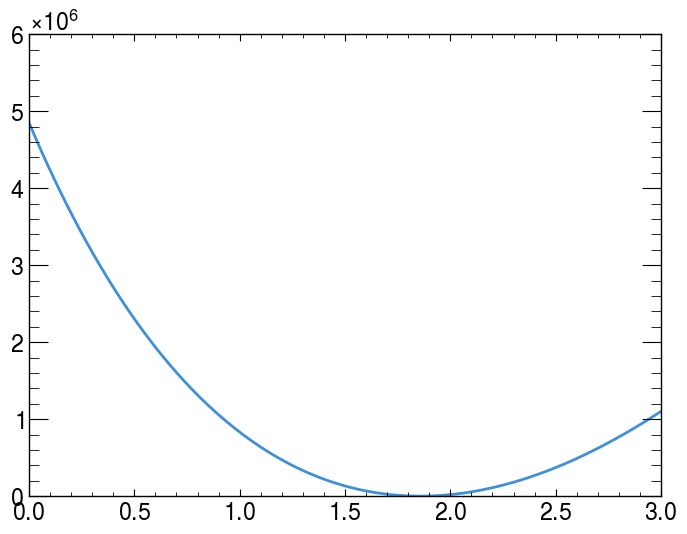

In [38]:
plt.plot(mu_scan_range, tmu_arr)
plt.axis(ymin=0.0)